### NN Model For Line Quality

Author: Jerry Chen

Neural network to predict line quality metrics

Input Parameters In Order
* Extruder Flowrate - Q (uL/min)
* Gantry Travel Speed - V<sub>g</sub> (mm/min)
* Layer Height (mm)

Output Parameters In Order
* Average Line Width - l<sub>w</sub>(μm)
* Average Line Height - l<sub>h</sub> (μm)

In [21]:
# Importing Useful libraries
import matplotlib.pylab as plt
import torch
import numpy as np

%matplotlib widget

torch.manual_seed(42)

use_cuda = True
device = 'cuda' if torch.cuda.is_available() and use_cuda else 'cpu'

# Class to represent dataset


class lineDataSet():

    def __init__(self):
        filename = "clean_data.csv"
        # Loading the csv file from the folder path
        # First row is data labels so delete
        data1 = np.loadtxt(filename, delimiter=',',
                           dtype=np.float32, skiprows=1)

        # First 3 column are inputs
        # Last 2 are columns are outputs
        # ['Q (uL/min)', 'Vg (mm/min)', 'Layer Height (mm)', 'Average Line Width (μm)', 'Average Line Height (μm)']

        # Zero center and normalize input and output data
        self.x = data1[:, [0, 1]]  # Shape Nx2
        self.input_mean = np.mean(self.x, axis=0)
        self.input_std = np.std(self.x, axis=0)
        self.x = torch.from_numpy((self.x-self.input_mean)/self.input_std)

        self.y = data1[:, [3, 4]]  # Shape Nx2
        self.output_mean = np.mean(self.y, axis=0)
        self.output_std = np.std(self.y, axis=0)
        self.y = torch.from_numpy((self.y-self.output_mean)/self.output_std)

        self.n_samples = data1.shape[0]

    # support indexing such that dataset[i] can
    # be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


dataset = lineDataSet()

first_data = dataset[0]
inputs, outputs = first_data
print(inputs, outputs)
print(inputs*dataset.input_std+dataset.input_mean,
      outputs*dataset.output_std+dataset.output_mean)

# Expected Output
# tensor([8.0976e+01, 1.9202e+03) tensor([364.2700,  78.4050]


tensor([-1.5394,  1.5381]) tensor([-1.8517, -1.8783])
tensor([  80.9764, 1920.2285]) tensor([364.2700,  78.4050])


In [22]:
import torch.nn as nn

# Network model
class Network(nn.Module):
    def __init__(self, channels=1):  # default grayscale
        super().__init__()
        # self.batch1 = nn.BatchNorm1d(2)
        # BEST 2-6 6-2 2-2
        self.linear1 = nn.Linear(in_features=2, out_features=4)
        self.linear2 = nn.Linear(in_features=4, out_features=6)
        self.linear3 = nn.Linear(in_features=6, out_features=4)
        #self.linear4 = nn.Linear(in_features=2, out_features=2)
        # self.linear5 = nn.Linear(in_features=2, out_features=2)
        # self.linear6 = nn.Linear(in_features=2, out_features=2)
        # self.linear7 = nn.Linear(in_features=2, out_features=2)
        self.out = nn.Linear(in_features=4, out_features=2)

    def forward(self, t):
        # t=self.batch1(t)
        t = self.linear1(t)
        t = torch.relu(t)
        t = self.linear2(t)
        t = torch.relu(t)
        t = self.linear3(t)
        t = torch.relu(t)
        #t = self.linear4(t)
        #t = torch.relu(t)
        # t = torch.tanh(t)
        # More layers generate more pronounced seperation
        # t = self.linear2(t)
        # t = F.tanh(t)
        t = self.out(t)
        return t


Using CUDA
step_size= 0.01 batch_size= 5 shuffle= True 

Prediction: 0.02 0.00 Actual: -1.09 -0.69
Prediction: -0.00 -0.06 Actual: 0.09 0.42
Prediction: -0.01 -0.01 Actual: 0.05 0.20
Prediction: 0.29 0.55 Actual: 1.79 1.09
Prediction: -0.93 -0.83 Actual: -1.44 -1.11
Prediction: 0.78 0.77 Actual: 1.79 1.09
Prediction: -0.96 -0.83 Actual: -1.44 -1.11
Prediction: 1.05 0.91 Actual: 1.79 1.09
Prediction: 0.32 0.20 Actual: 0.09 0.42
Prediction: 0.20 0.07 Actual: 0.09 0.42
Prediction: -1.03 -0.85 Actual: -1.44 -1.11
Prediction: -1.91 -1.79 Actual: -1.85 -1.88
Prediction: 0.08 0.02 Actual: 0.09 0.42
Prediction: -0.88 -0.77 Actual: -1.09 -0.69
Prediction: 0.50 0.34 Actual: -0.13 0.10
Prediction: -0.93 -0.80 Actual: -1.44 -1.11
Prediction: -1.75 -1.63 Actual: -1.85 -1.88
Prediction: -0.35 -0.19 Actual: -0.56 0.29
Prediction: 0.09 -0.11 Actual: 0.05 0.20
Prediction: -1.08 -0.99 Actual: -1.09 -0.69
Prediction: 0.07 0.08 Actual: 0.17 0.16
Prediction: 0.17 0.28 Actual: 0.17 0.16
Prediction: 0.05 -0.

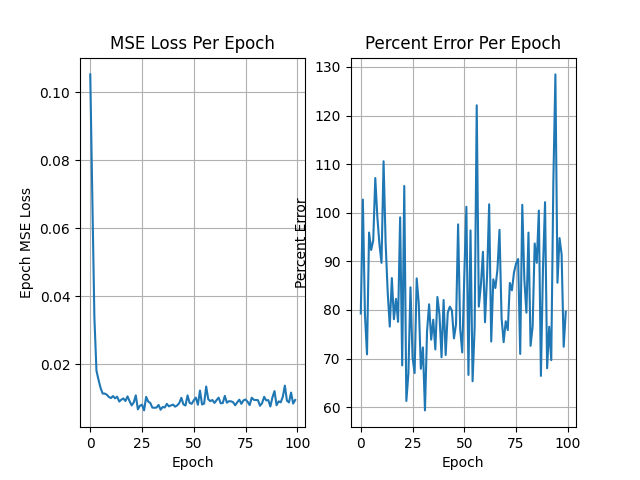

In [25]:
# Training
def train(step_size, batch_size=5, shuffle=False, num_epochs=10, plot_loss=False):
    # Loading in data
    dataset = lineDataSet()
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size])

    dsets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

    # Data loading - batch_size and shuffle
    dset_loader = {x: torch.utils.data.DataLoader(
        dsets[x], batch_size=batch_size, shuffle=shuffle) for x in ['train', 'val', 'test']}

    # Start network
    network = Network()
    if device == "cuda":
        print("Using CUDA")
        network.cuda()

    # Training
    print('step_size=', step_size, 'batch_size=',
          batch_size, 'shuffle=', shuffle, '\n')

    optimizer = torch.optim.Adam(network.parameters(), lr=step_size)

    best_epoch = 0
    best_epoch_loss = np.inf
    epoch_losses = []
    epoch_percent_error = []
    for epoch in range(num_epochs):

        avg_epoch_loss = 0
        avg_epoch_percent_error = 0

        for mode in ['train', 'val']:
            if mode == 'train':
                network.train(True)    # Set model to training mode
            else:
                network.train(False)    # Set model to evaluation mode
                network.eval()

            for input_val, out_val in dset_loader[mode]:

                if device == "cuda":
                    input_val = input_val.cuda()
                    out_val = out_val.cuda()

                optimizer.zero_grad()    # Zero the gradients of the network weights prior to backprop

                # Forward pass through the network - Shape batch x output
                preds = network(input_val)

                # Compute the minibatch loss with mean squared error
                minibatch_loss = torch.nn.functional.mse_loss(preds, out_val)

                if mode == 'val':
                    # Percent error divide
                    avg_epoch_percent_error += 100*torch.sum(torch.abs((preds-out_val)/out_val))

                    # Total epoch loss sum minibatch_loss
                    avg_epoch_loss += minibatch_loss

                    # raise Exception("Finished code")

                if mode == 'train':  # only backprop with training set
                    minibatch_loss.backward()
                    optimizer.step()

            if mode == 'val':
                # Per element percent error, muliply by 2 because 2 outputs per datapoint
                avg_epoch_percent_error /= 2*val_size
                epoch_percent_error.append(
                    avg_epoch_percent_error.cpu().detach().numpy())

                epoch_losses.append(avg_epoch_loss.cpu().detach().numpy())

                #print(f"epoch:{epoch}\t avg_val_MSE_error:{avg_epoch_loss}")
                print("Prediction: {:.2f} {:.2f} Actual: {:.2f} {:.2f}".format(
                    preds[0][0].item(), preds[0][1].item(),
                    out_val[0][0].item(), out_val[0][1].item()))

                if avg_epoch_loss < best_epoch_loss:
                    best_epoch_loss = avg_epoch_loss
                    best_epoch = epoch
                    torch.save(network.state_dict(), f'best_model.pth')

    print(f"Best epoch {best_epoch}")

    if plot_loss:
        fig, ax = plt.subplots(1, 2)
        ax[0].plot([i for i in range(num_epochs)], epoch_losses)
        ax[0].set(xlabel='Epoch', ylabel='Epoch MSE Loss',
               title='MSE Loss Per Epoch')
        ax[0].grid()

        ax[1].plot([i for i in range(num_epochs)], epoch_percent_error)
        ax[1].set(xlabel='Epoch', ylabel='Percent Error',
               title='Percent Error Per Epoch')
        ax[1].grid()

        #plt.savefig("Epoch Loss.png", dpi=300)
        plt.show()

    return network


lr_list = [0.1, 0.01, 0.001]
batch_size_list = [10, 100, 1000]
shuffle_list = [True, False]

# hyperparameter grid search
# for param in product(lr_list, batch_size_list, shuffle_list):


best_network = train(0.01, shuffle=True, num_epochs=100, plot_loss=True)


Network(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (linear2): Linear(in_features=4, out_features=6, bias=True)
  (linear3): Linear(in_features=6, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=2, bias=True)
)
tensor([[-0.2920,  0.1361],
        [-0.8975,  0.0913],
        [ 0.8926, -1.0890],
        [-1.0945,  0.3461]])
tensor([-0.7348, -0.7437,  0.7346, -0.3483])
tensor([[ 0.1541, -0.4663, -0.3284, -0.1664],
        [ 0.0782, -0.4400, -0.2154, -0.2993],
        [ 0.0014, -0.2377, -0.1789, -0.4128],
        [-0.3432, -0.2917, -0.1711, -0.3946],
        [ 0.2975, -0.4882,  0.8990, -0.4768],
        [-0.4234,  0.3460, -0.1376, -0.1917]])
tensor([-0.4150, -0.4971, -0.0128, -0.1092,  0.7938, -0.4103])
tensor([[ 0.3031, -0.2997, -0.0705,  0.0853,  0.0450,  0.3296],
        [ 0.3719, -0.3237,  0.0100, -0.1756, -0.3337, -0.3056],
        [ 0.3719, -0.2996,  0.0695,  0.1435, -0.0467, -0.2207],
        [ 0.3711,  0.0897,  0.0525, -0.3598,  0.8404, -

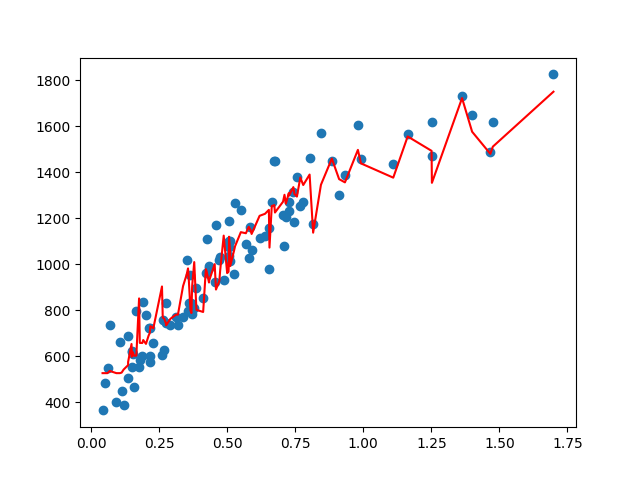

In [24]:
dataset = lineDataSet()

best_network = Network()
best_network.load_state_dict(torch.load('best_model.pth'))


print(best_network)

for m in best_network.modules():
    if isinstance(m, nn.Linear):
        print(m.state_dict()['weight'])
        print(m.state_dict()['bias'])


# Turn of gradiant
with torch.no_grad():
    best_network.eval()

    network = best_network.cpu()

    pred = network(dataset[:][0])

    # X = [Q (uL/min), Vg (mm/min)]
    # Y =  [Average Width (μm), Average Thickness (μm)]
    Q = dataset[:][0][:, 0]*dataset.input_std[0]+dataset.input_mean[0]
    Q = Q.numpy()
    flow_rate_sort_idx = np.argsort(Q)
    Q = Q[flow_rate_sort_idx]

    Vg = dataset[:][0][:, 1]*dataset.input_std[1]+dataset.input_mean[1]
    Vg = Vg.numpy()
    Vg = Vg[flow_rate_sort_idx]

    avg_width = dataset[:][1][:, 0] * \
        dataset.output_std[0]+dataset.output_mean[0]
    avg_width = avg_width.numpy()
    avg_width = avg_width[flow_rate_sort_idx]

    avg_width_pred = pred[:, 0] * \
        dataset.output_std[0] + dataset.output_mean[0]
    avg_width_pred = avg_width_pred.numpy()
    avg_width_pred = avg_width_pred[flow_rate_sort_idx]


    QVg=Q/Vg
    QVg_index= np.argsort(QVg)
    QVg=QVg[QVg_index]

    fig = plt.figure()
    ax=plt.axes()
    ax.plot(QVg, avg_width_pred[QVg_index],'r')
    ax.scatter(QVg, avg_width[QVg_index])
    #ax = plt.axes(projection="3d")

    #ax.scatter(Q, Vg, avg_width,  edgecolor='royalblue')
    #ax.scatter(Q, Vg, avg_width_pred,  edgecolor='royalblue')
    #ax.plot_trisurf(Q, Vg, avg_width,  edgecolor='royalblue')
    #ax.plot_trisurf(Q, Vg, avg_width_pred,  edgecolor='r')
    plt.show()

    '''
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    axs[0].plot(Q, avg_width, 'r')
    #axs[0].plot(Q, avg_width_pred, 'b')
    #axs[0].set_xlabel("Flow Rate")
    #axs[0].set_ylabel("Gantry Speed")
    #axs[0].set_zlabel("Print Width")
    axs[0].grid(True)

    # axs[1].plot(dataset[:][0][:, 0]+dataset.input_mean[2],
    #            dataset[:][1][:, 1], 'r')
    # axs[1].plot(dataset[:]# Q (uL/min), Vg (mm/min),LDR (μL/mm), Print Height (mm), Average Width (μm), Average Thickness (μm)[0][:, 0]+dataset.input_mean[2], pred[:, 1], 'b')
    # axs[1].set_xlabel("LDR")
    # axs[1].set_ylabel("Average Height")
    # axs[1].grid(True)

    plt.tight_layout()
    plt.show()
  
    # for param in network.parameters():
    #    print(param)
    '''